In [1]:
# Setup the environment for google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl wurlitzer "jiminy_py[meshcat]" "panda3d-simplepbr==0.10" > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot.urdf -O robot.urdf > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot_hardware.toml -O robot_hardware.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot_options.toml -O robot_options.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_1.toml -O part_1.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_2.toml -O part_2.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_3.toml -O part_3.toml > /dev/null 2>&1
except ImportError:
    pass

In [2]:
# This module forward C++ errors to Python to help debugging
%load_ext wurlitzer

In [3]:
# Enable matplotlib interactive notebook integration
%matplotlib widget

In [4]:
# Generic import that will be useful throughout this notebook
import numpy as np

# The main module of jiminy
import jiminy_py.core as jiminy
from jiminy_py.simulator import Simulator

# Import low-level Rigid-Body Dynamics library
import pinocchio as pin

In [5]:
# Instantiate the robot
simulator = Simulator.build(urdf_path="robot.urdf", has_freeflyer=False)

# Import "part_<X>.toml") to load exercice <X> by increasing difficulty up to 3, then comment out import
simulator.import_options("part_3.toml")

In [6]:
# Get the list of available sensors
simulator.robot.sensors_names

{'EffortSensor': ['PendulumJoint'],
 'EncoderSensor': ['PendulumJoint'],
 'ImuSensor': ['PendulumMass']}

In [7]:
# Define gravity and get mass of the pole
gravity = 9.81
mass = simulator.robot.pinocchio_data.mass[0]
length = simulator.robot.pinocchio_data.oMf[-2].translation[-1]

In [8]:
angle_desired = 0.0

# Define the command: for now, the motor outputs zero torque.
def compute_command(t, q, v, sensors_data, command):
    global angle_desired
    q_mot, v_mot = sensors_data['EncoderSensor', 'PendulumJoint']
    k_flex, k_control = 500.0, 100.0
    k_mean = 1.0 / (1.0 / k_flex + 1.0 / k_control)
    q_flex = 0.0
    for _ in range(2):
      q_target = angle_desired - gravity * length * mass * np.sin(q_mot + q_flex) / k_mean
      q_flex = (k_control / k_flex) * (q_mot - q_target)
    command[:] = - k_control * ((q_mot - q_target) + 0.3 * v_mot)

# Instantiate the controller and attach it to the robot
controller = jiminy.ControllerFunctor(compute_command)
controller.initialize(simulator.robot)
simulator.set_controller(controller)

jiminy_py.core.hresult_t.SUCCESS

In [9]:
for _ in range(10):
    # Set initial condition and target pole angle
    q_init = pin.neutral(simulator.robot.pinocchio_model_th)
    v_init = np.random.rand(simulator.robot.pinocchio_model_th.nv)

    # Launch the simulation
    angle_desired = np.pi * np.random.rand()
    simulator.simulate(t_end=3.0, q_init=q_init, v_init=v_init, is_state_theoretical=True)

    # Check it the desired pole angle has been reached within acceptable margins
    print("Desired pole angle:", angle_desired)
    gyro_data, accel_data = np.split(simulator.robot.sensors_data['ImuSensor', 'PendulumMass'].copy(), 2)
    assert np.allclose(gyro_data, 0.0, atol=1e-3), "Pole has not reached equilibrium"
    angle = np.arctan2(*accel_data[1:])
    error_angle = min(np.abs(angle - angle_desired), 2.0 * np.pi - np.abs(angle - angle_desired))
    print("Error pole angle:", error_angle)
    assert error_angle < 1e-3, f"Error is too large: measured={angle:.3f}, target={angle_desired:.3f}"

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

  0%|          | 0.00/3.0 [00:00<?]

In [10]:
# Replay the simulation
camera_pose = ([-5.0, 0.0, 0.0], [np.pi/2, 0.0, -np.pi/2])
simulator.replay(camera_pose=camera_pose, speed_ratio=1.0, record_video_size=(400, 400))
simulator.close()

Attempt to register type x11GraphicsPipe more than once!
Attempt to register type x11GraphicsWindow more than once!
Rendering frames: 100%|██████████| 90/90 [00:02<00:00, 39.14it/s]


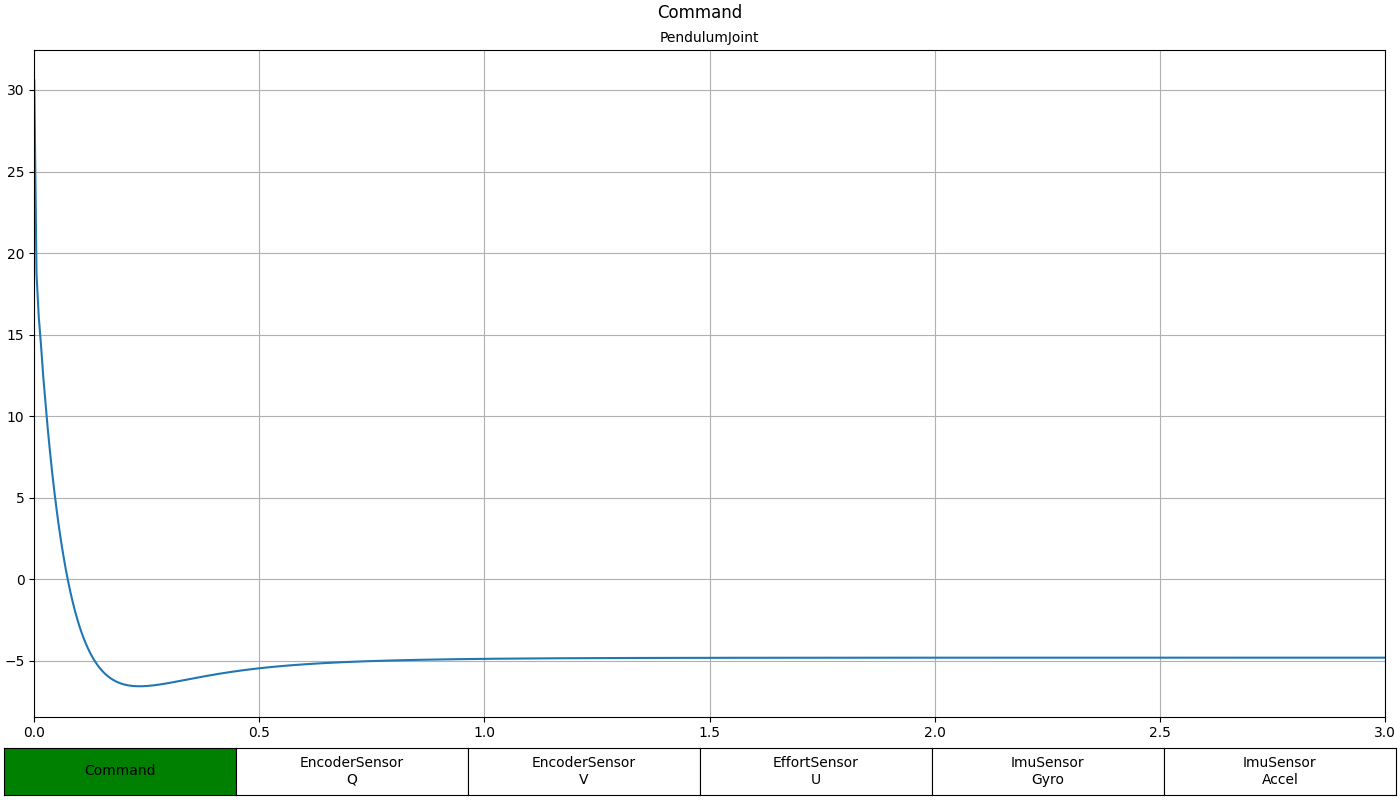

In [11]:
# Plot some metrics
fig_tabbed = simulator.plot(enable_flexiblity_data=False)
for tab_name in ('State Position', 'ForceSensor F', 'ForceSensor M'):
  fig_tabbed.remove_tab(tab_name)